# Time Leading, Traing Ties v2.0
- Started 11-11-24

In [1]:
### Path to Target Database file
import os
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.legend_handler import HandlerTuple
from matplotlib.legend_handler import HandlerBase
from PIL import Image

from bs4 import BeautifulSoup
import requests

# path to database file using os module
# data\db\2024_Nov_7_SEMI_CLEAN.db
# db_path = os.path.join('..', 'data', 'db', '2024_Dec_10_CLEANED_OLD_METHOD.db') # Path to most recent cleaned DB File
db_path = os.path.join('..', 'data', 'db', '2025_Jan_16_CLEAN.db') # Path to most recent cleaned DB File
# db_path = os.path.join('..', 'TEMP', '2024_Dec_18_CLEAN.db') # Path to most recent cleaned DB File
conn = sqlite3.connect(db_path)

# output_file_path = '../TEMP/lead_Trail_season_aggregate_states.csv' # Original Path - power BI report is tied to tis file location
output_file_path = '../TEMP/Lead_Trail_v3_TEST.csv'

# verify the connection
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# extract scoring table from database
scoring_query = "SELECT * FROM scoring_summary"
scoring_df = pd.read_sql_query(scoring_query, conn)

# Clean Up Team names
# Drop any non-letter characters from the Team, Away_Team, and Home_Team columns
scoring_df['Team'] = scoring_df['Team'].str.replace(r'[^a-zA-Z]', '')
scoring_df['Away_Team'] = scoring_df['Away_Team'].str.replace(r'[^a-zA-Z]', '')
scoring_df['Home_Team'] = scoring_df['Home_Team'].str.replace(r'[^a-zA-Z]', '')

# scoring_df.head()

### Dictionaries and Constants

In [2]:
# path to TEMP folder
temp_folder = os.path.join(os.getcwd(), '..', 'TEMP')
# Data folder
data_folder = os.path.join(os.getcwd(), '..', 'data')
# Image folder
img_folder = os.path.join(os.getcwd(), '..', 'images')
# Logo folder
logo_folder = os.path.join(os.getcwd(), '..', 'images', 'logos')

# Path to school info table (csv)
school_info_file = os.path.join(data_folder, 'arena_school_info.csv')
school_info_df = pd.read_csv(school_info_file)

## Conference Membership

atlantic = ['Air Force', "American Intl", 'Army', 'Bentley', 'Canisius', 'Holy Cross', 'Mercyhurst', 
            'Niagara', 'RIT', 'Robert Morris', 'Sacred Heart']

big_ten = ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin']

ccha = ['Augustana', 'Bemidji State', 'Bowling Green', 'Ferris State', 'Lake Superior', 'Michigan Tech', 
        'Minnesota State', 'Northern Michigan', 'St Thomas']

ecac = ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
        'Rensselaer', 'St Lawrence', 'Union', 'Yale']

hockey_east = ['Boston College', 'Boston University', 'Connecticut', 'Maine', 'Massachusetts', 'Mass Lowell',
                'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont']

nchc = ['Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 'St Cloud State',
        'Western Michigan']

independents = ['Alaska Anchorage', 'Alaska', 'Lindenwood', 'Long Island', 'Stonehill']

# Create a dictionary of {Team: logo_abv} for each team with .png added to the end
logo_mapping = {}

for index, row in school_info_df.iterrows():
    logo_mapping[row['Team']] = row['logo_abv'] + '.png'

# print(logo_mapping)

In [3]:
title_font_size = 28
legend_title_font_size = 24
legend_font_size = 20
legend_font_size_2 = 16
set_x_label_font_size = 16
set_x_label_font_size_2 = 18

### Select scoring summary table 

In [4]:
# Step 1: Preprocess the data to convert 'Time' and 'Period' into cumulative seconds
def convert_time_to_seconds(time_str):
    """Convert 'MM:SS' format to total seconds."""
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

def convert_period_to_seconds(period, time_in_period):
    """Convert period and time in period to cumulative game seconds."""
    base_time = 0
    if period == '1st Period':
        base_time = 0
    elif period == '2nd Period':
        base_time = 1200  # 20 minutes
    elif period == '3rd Period':
        base_time = 2400  # 40 minutes
    elif period == 'Overtime':
        base_time = 3600  # 60 minutes (end of regulation)
    return base_time + time_in_period

# Apply the conversions to the dataframe
scoring_df['Time_Seconds'] = scoring_df['Time'].apply(convert_time_to_seconds)
scoring_df['Cumulative_Seconds'] = scoring_df.apply(
    lambda row: convert_period_to_seconds(row['Period'], row['Time_Seconds']), axis=1
)

# Sort the dataframe by Game_ID and Cumulative_Seconds to process goals in order
scoring_df.sort_values(by=['Game_ID', 'Cumulative_Seconds'], inplace=True)

# Display the processed dataframe to check the conversion results
# import ace_tools as tools; tools.display_dataframe_to_user(name="Processed Scoring Data", dataframe=scoring_df)


### FORK ADDED 1-4-25
- use the df in its current state to do analyis of teams leading and trailing events

In [5]:
# Output the processed dataframe to a CSV file
# scoring_df.to_csv(os.path.join(temp_folder, 'processed_scoring_data.csv'), index=False)

In [6]:
# Rename scoring_df to scoring_data for add-on code
scoring_data = scoring_df
# Concise code block to generate the required dataframe
from collections import defaultdict

# Initialize counters for events
lead_taking_counts = defaultdict(int)
trailing_event_counts = defaultdict(int)
lead_to_tie_counts = defaultdict(int)
trailing_to_tie_counts = defaultdict(int)


# Process each game to calculate all events
for game_id, game_data in scoring_data.groupby("Game_ID"):
    # Sort the game data chronologically by cumulative time
    game_data_sorted = game_data.sort_values(by="Cumulative_Seconds")
    
    # Identify the teams playing in the game
    away_team = game_data_sorted["Away_Team"].iloc[0]
    home_team = game_data_sorted["Home_Team"].iloc[0]
    teams = {away_team, home_team}
    
    # Initialize scores
    scores = {team: 0 for team in teams}
    
    for _, row in game_data_sorted.iterrows():
        team = row["Team"]
        opposing_team = [t for t in teams if t != team][0]  # Get the other team
        
        # Update the score for the scoring team
        scores[team] += 1
        
        # Lead taking: Breaking a tie to take the lead
        if scores[team] == scores[opposing_team] + 1 and scores[opposing_team] == scores[team] - 1:
            lead_taking_counts[team] += 1
        
        # Trailing event: Opponent breaks a tie to take the lead
        if scores[team] == scores[opposing_team] - 1 and scores[opposing_team] == scores[team] + 1:
            trailing_event_counts[team] += 1
        
        # Lead to tie: Scoring team's lead is neutralized
        if scores[team] == scores[opposing_team] and scores[opposing_team] > scores[team] - 1:
            lead_to_tie_counts[opposing_team] += 1
        
        # Trailing to tie: Scoring team neutralizes opponent's lead
        if scores[team] == scores[opposing_team] and scores[team] < scores[opposing_team] + 1:
            trailing_to_tie_counts[team] += 1

# Compile results into a dataframe
event_counts_df = pd.DataFrame({
    "Team": list(lead_taking_counts.keys()),
    "Lead Taking Events": list(lead_taking_counts.values()),
    "Trailing Events": [trailing_event_counts[team] for team in lead_taking_counts.keys()],
    "Lead to Tie Events": [lead_to_tie_counts[team] for team in lead_taking_counts.keys()],
    "Trailing to Tie Events": [trailing_to_tie_counts[team] for team in lead_taking_counts.keys()]
})

In [7]:
### Examining the results
event_counts_df.head(10)
# event_counts_df.info()

######## RESULTS INACURATE ######## FOR TRAILING EVENTS AT LEAST



,Team,Lead Taking Events,Trailing Events,Lead to Tie Events,Trailing to Tie Events
0,Arizona State,22,4,11,8
1,Bowling Green,20,5,9,12
2,Connecticut,20,5,9,11
3,Miami,12,5,9,9
4,Michigan State,30,4,12,13
5,Michigan,23,3,10,9
6,Minnesota State,24,4,9,7
7,Maine,21,3,6,7
8,Air Force,14,3,3,12
9,Bemidji State,24,10,16,14


#
### END ADDED

In [8]:
############# HOTFIX REPLACE ABREVIATIONS WITH FULL TEAM NAMES IF NEEDED ################
def clean_team_name(team_name):
    """
    Cleans the team name by removing unwanted characters.
    Args:
        team_name (str): Team name.

    Returns:
        str: Cleaned team name.
    """
    # Replace unwanted characters with an empty string
    return team_name.replace('-', ' ').replace('.', '').replace("'", '').strip()

## Load school infomation from arena_school_info.csv
school_info_df = pd.read_csv(os.path.join('..', 'data', 'arena_school_info.csv'))

# Create a dictionary for abbreviations to full team names
abbreviation_to_fullname = school_info_df.set_index('abv')['Team'].to_dict()

# Define a function to replace abbreviations in a column with full team names
def replace_abbreviations_with_fullnames(df, column_name, abbreviation_dict):
    """
    Replaces abbreviations in the specified column of a DataFrame with full team names.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the column to process.
        column_name (str): The column name where abbreviations need to be replaced.
        abbreviation_dict (dict): Dictionary mapping abbreviations to full names.
    
    Returns:
        pd.DataFrame: DataFrame with updated column values.
    """
    df[column_name] = df[column_name].replace(abbreviation_dict)
    return df
####################

# Replace abbreviations with full team names in the 'Team' column
scoring_df = replace_abbreviations_with_fullnames(scoring_df, 'Team', abbreviation_to_fullname)

# # Clean Up Team names using the clean_team_name function
# scoring_df['Team'] = scoring_df['Team'].apply(clean_team_name)

# Examine the abbreviation_to_fullname dictionary
print(abbreviation_to_fullname)

{'Air Force': 'Air Force', 'Alaska': 'Alaska', 'UAA': 'Alaska Anchorage', 'AIC': 'American Intl', 'ASU': 'Arizona State', 'Army': 'Army', 'BSU': 'Bemidji State', 'Bentley': 'Bentley', 'BC': 'Boston College', 'BU': 'Boston University', 'BGSU': 'Bowling Green', 'Brown': 'Brown', 'Canisius': 'Canisius', 'Clarkson': 'Clarkson', 'Colgate': 'Colgate', 'CC': 'Colorado College', 'UConn': 'Connecticut', 'Cornell': 'Cornell', 'Dartmouth': 'Dartmouth', 'Denver': 'Denver', 'FSU': 'Ferris State', 'Harvard': 'Harvard', 'HC': 'Holy Cross', 'LSSU': 'Lake Superior', 'LIU': 'Long Island', 'UML': 'Mass. Lowell', 'UMass': 'Massachusetts', 'Mercyhurst': 'Mercyhurst', 'Merrimack': 'Merrimack', 'Miami': 'Miami', 'Michigan': 'Michigan', 'MSU': 'Michigan State', 'MTU': 'Michigan Tech', 'Minnesota': 'Minnesota', 'MnSU': 'Minnesota State', 'UMD': 'Minnesota Duluth', 'UNH': 'New Hampshire', 'Niagara': 'Niagara', 'UND': 'North Dakota', 'Northeastern': 'Northeastern', 'NMU': 'Northern Michigan', 'NDame': 'Notre Dam

In [9]:
# Clean the team names in the dictionary

In [10]:
from collections import defaultdict

def calculate_game_states(scoring_df):
    """
    Calculate time spent in different game states (tied, leading by 1, leading by 2+, trailing by 1, etc.)
    for each team in each game.
    """
    # Initialize a dictionary to store results
    results = defaultdict(lambda: defaultdict(int))
    
    # Group by each game and sort by cumulative seconds
    games = scoring_df.groupby('Game_ID')
    
    for game_id, game_data in games:
        game_data = game_data.sort_values('Cumulative_Seconds')
        
        # Extract home and away teams
        home_team = game_data['Home_Team'].iloc[0]
        away_team = game_data['Away_Team'].iloc[0]
        
        # Initialize scores and time tracking
        scores = {home_team: 0, away_team: 0}
        previous_time = 0
        
        # Function to determine game state
        def get_game_state(team, scores):
            opponent = home_team if team == away_team else away_team
            goal_diff = scores[team] - scores[opponent]
            
            if goal_diff == 0:
                return 'Tied'
            elif goal_diff == 1:
                return 'Leading by 1'
            elif goal_diff == 2:
                return 'Leading by 2'
            elif goal_diff >= 3:
                return 'Leading by 3+'
            elif goal_diff == -1:
                return 'Trailing by 1'
            elif goal_diff == -2:
                return 'Trailing by 2'
            else:
                return 'Trailing by 3+'

        # Track the game states as goals are scored
        for _, row in game_data.iterrows():
            current_time = row['Cumulative_Seconds']
            elapsed_time = current_time - previous_time
            
            # Calculate the current state for both teams before the goal
            for team in [home_team, away_team]:
                state = get_game_state(team, scores)
                results[team][state] += elapsed_time
            
            # Update the score for the team that scored
            scores[row['Team']] += 1
            
            # Update the previous time to the current goal time
            previous_time = current_time
        
        # Handle the final game state after the last goal to the end of the game (60 or 65 minutes)
        game_end_time = 3900 if 'Overtime' in game_data['Period'].values else 3600
        remaining_time = game_end_time - previous_time
        
        for team in [home_team, away_team]:
            state = get_game_state(team, scores)
            results[team][state] += remaining_time

    # Convert results to a DataFrame for easy analysis
    result_df = pd.DataFrame(results).fillna(0).transpose()
    result_df.reset_index(inplace=True)
    result_df.rename(columns={'index': 'Team'}, inplace=True)
    
    return result_df

# Clean the Team names using the clean_team_name function
scoring_df['Team'] = scoring_df['Team'].apply(clean_team_name)

################# DEAD CODE #################
            # # Hotfix Add . back to St. Lawrence
            # scoring_df['Team'] = scoring_df['Team'].replace('St Lawrence', 'St. Lawrence')
            # # # St. Cloud State
            # scoring_df['Team'] = scoring_df['Team'].replace('St Cloud State', 'St. Cloud State')
            # # American Intl
            # scoring_df['Team'] = scoring_df['Team'].replace('American Intl', "American Int'l")
            # # Mass Lowell
            # scoring_df['Team'] = scoring_df['Team'].replace('Mass Lowell', 'Mass. Lowell')
            # # St Thomas
            # scoring_df['Team'] = scoring_df['Team'].replace('St Thomas', 'St. Thomas')


# Calculate the game states using the function
game_states_df = calculate_game_states(scoring_df)

# Output the game states to a CSV file for checking
game_states_df.to_csv(output_file_path, index=False)

# Display the result
# tools.display_dataframe_to_user(name="Team Game State Analysis", dataframe=game_states_df)


In [11]:
# game_states_df
# Find instances with Mass Lowell in scoring_df
# scoring_df[scoring_df['Team'].str.contains('Mass Lowell')]


In [12]:
# ## As a QCheck get a total time and divide by 60 to get minutes
# # Set the index to the team name
# game_states_df.set_index('Team', inplace=True)
# game_states_df['Total_Time'] = game_states_df.sum(axis=1)
# game_states_df['Total_Time_Minutes'] = game_states_df['Total_Time'] / 60


# game_states_df.head(10)

### Calculate percentages for each game state

In [13]:
# Calculate the total time for each team and add the percentage columns
game_states_df['Total_Time'] = game_states_df[['Tied', 'Trailing by 1', 'Trailing by 2', 'Trailing by 3+',
                                               'Leading by 1', 'Leading by 2', 'Leading by 3+']].sum(axis=1)

# Calculate the percentage of time spent in each state
game_states_df['Tied_Percentage'] = game_states_df['Tied'] / game_states_df['Total_Time'] * 100
game_states_df['Leading_by_1_Percentage'] = game_states_df['Leading by 1'] / game_states_df['Total_Time'] * 100
game_states_df['Leading_by_2_Percentage'] = game_states_df['Leading by 2'] / game_states_df['Total_Time'] * 100
game_states_df['Leading_by_3+_Percentage'] = game_states_df['Leading by 3+'] / game_states_df['Total_Time'] * 100
game_states_df['Trailing_by_1_Percentage'] = game_states_df['Trailing by 1'] / game_states_df['Total_Time'] * 100
game_states_df['Trailing_by_2_Percentage'] = game_states_df['Trailing by 2'] / game_states_df['Total_Time'] * 100
game_states_df['Trailing_by_3+_Percentage'] = game_states_df['Trailing by 3+'] / game_states_df['Total_Time'] * 100

# Re-run the plotting function to visualize the top teams by leading percentage
# plot_top_teams_by_leading_percentage(game_states_df)




# Visualizations

#### Helper Functions

In [14]:
### TEST CODE FOR NEW LEGEND

def add_refined_legend(ax, colors, legend_font_size=10):
    """
    Add a modern, streamlined legend to the plot with colors aligned horizontally,
    with two rows of text for the degree of lead/deficit and guide labels.
    """
    # Get todays date as a string for the footer
    from datetime import date
    today = date.today()
    todays_date = today.strftime("%m/%d/%Y")

    # Legend labels for the top row (inside the swatches)
    degree_labels = ["3+", "2", "1", "", "1", "2", "3+"]
    
    # Guide labels for the bottom row
    guide_labels = ["Lead", "Tied", "Trail"]
    
    # Calculate the position and width of the legend
    legend_x = 0.5  # Centered on the x-axis
    legend_width = 0.75  # Span 75% of the plot width

    # Create rectangles for each color swatch
    swatches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
    
    # Create a legend with swatches and the degree labels
    legend = ax.legend(
        swatches, degree_labels, loc='upper center',
        bbox_to_anchor=(legend_x, -0.075), ncol=len(colors), frameon=False,
        fontsize=legend_font_size, handlelength=7.0, 
        handletextpad=0.15, columnspacing=0.5
    )
    
    # Center the text inside the swatches
    for text, label in zip(legend.get_texts(), degree_labels):
        text.set_ha('center')
        text.set_va('center')

    # Add the bottom guide labels ("Lead", "Tied", "Down")
    ax.text(
        0.15, -0.15, guide_labels[0], ha='center', va='center', transform=ax.transAxes, fontsize=legend_font_size_2
    )
    ax.text(
        0.5, -0.15, guide_labels[1], ha='center', va='center', transform=ax.transAxes, fontsize=legend_font_size_2
    )
    ax.text(
        0.85, -0.15, guide_labels[2], ha='center', va='center', transform=ax.transAxes, fontsize=legend_font_size_2
    )
    
     # add a note with the date the data was pulled and plotted
    ax.text(0.5, -0.2, f'Data Source: College Hockey News. Includes all games through {todays_date}', ha='center', va='bottom',
     fontsize=12, 
    transform=ax.transAxes
    )

### Options and Settings

In [15]:
## Set the figure size / ratio
set_fig_size = (9, 10)

## Color Scheme from the Original Tableau Viz
colors = [
    '#1A9850', '#65BD62', '#A6D86A',  # Leading: Dark Blue, Light Blue, Steel Blue
    '#FFFFBF',                        # Tied: Dark Gray
    '#FCAE62', '#F36D42', '#D73026'   # Trailing: Light Red, Orange Red, Dark Red
]

#### Adjustable Plot Backend

In [16]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os

def plot_team_comparison(game_states_df, logo_mapping, logo_folder, plot_type, top_n=10):
    """
    Plot stacked bar charts of game state percentages for the top `top_n` teams,
    with labels showing the percentage within each segment if space allows,
    and team logos replacing the team names on the y-axis.
    
    Parameters:
    - game_states_df: DataFrame containing game state data.
    - logo_mapping: Dictionary mapping team names to logo file names.
    - logo_folder: Folder path where logos are stored.
    - plot_type: Type of plot ("leading", "trailing", "tied", "least_tied").
    - top_n: Number of top teams to display.
    """
    
    # Calculate the total percentages for leading, trailing, and tied states
    game_states_df['Total_Leading_Percentage'] = (
        game_states_df['Leading_by_1_Percentage'] +
        game_states_df['Leading_by_2_Percentage'] +
        game_states_df['Leading_by_3+_Percentage']
    )
    game_states_df['Total_Trailing_Percentage'] = (
        game_states_df['Trailing_by_1_Percentage'] +
        game_states_df['Trailing_by_2_Percentage'] +
        game_states_df['Trailing_by_3+_Percentage']
    )
    game_states_df['Total_Tied_Percentage'] = game_states_df['Tied_Percentage']

    # Select the top teams based on the chosen plot type
    if plot_type == "leading":
        top_teams_df = game_states_df.nlargest(top_n, 'Total_Leading_Percentage')
        title = f"Highest % of Game Time Leading"
    elif plot_type == "trailing":
        top_teams_df = game_states_df.nlargest(top_n, 'Total_Trailing_Percentage')
        title = f"Highest % of Game Time Trailing"
    elif plot_type == "tied":
        top_teams_df = game_states_df.nlargest(top_n, 'Total_Tied_Percentage')
        title = f"Highest % of Game Time Tied"
    elif plot_type == "least_tied":
        top_teams_df = game_states_df.nsmallest(top_n, 'Total_Tied_Percentage')
        title = f"Lowest % of Game Time Tied"
    else:
        raise ValueError("Invalid plot type. Choose from 'leading', 'trailing', 'tied', 'least_tied'.")

    # Prepare data for plotting
    categories = [
        'Leading_by_3+_Percentage', 'Leading_by_2_Percentage', 'Leading_by_1_Percentage',
        'Tied_Percentage', 'Trailing_by_1_Percentage', 'Trailing_by_2_Percentage', 'Trailing_by_3+_Percentage'
    ]
    
    colors = [
        '#1A9850', '#65BD62', '#A6D86A',  # Leading: Shades of Green
        '#FFFFBF',                        # Tied: Yellow
        '#FCAE62', '#F36D42', '#D73026'   # Trailing: Shades of Red
    ]

    custom_labels = [
        'Lead 3+', 'Lead 2', 'Lead 1', 
        'Tied', 'Down 1', 'Down 2', 'Down 3+'
    ]
    
    fig, ax = plt.subplots(figsize=set_fig_size)
    
    bottom = None
    for category, color in zip(categories, colors):
        if bottom is None:
            bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category)
            bottom = top_teams_df[category]
        else:
            bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category, left=bottom)
            bottom += top_teams_df[category]
        
        # Add labels to the segments where there's enough space
        for bar, value in zip(bars, top_teams_df[category]):
            if value > 5:  # Only show labels if the segment is larger than 5%
                ax.text(
                    bar.get_x() + bar.get_width() / 2, 
                    bar.get_y() + bar.get_height() / 2, 
                    f"{value:.1f}%", ha='center', va='center', fontsize=12, color='black'
                )

    # Add team logos in place of the y-axis labels
    for i, team in enumerate(top_teams_df['Team']):
        logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))
        if logo_path and os.path.exists(logo_path):
            try:
                logo_img = plt.imread(logo_path)
                imagebox = OffsetImage(logo_img, zoom=0.15)
                ab = AnnotationBbox(imagebox, (0, i), frameon=False, boxcoords="offset points", 
                                    xybox=(-25, 0), pad=0, xycoords='data')
                ax.add_artist(ab)
            except Exception as e:
                print(f"Error adding logo for {team}: {e}")

    # Remove y-axis labels since we are using logos
    ax.set_yticks([])
    
    # Customize the chart
    ax.set_xlabel('Percentage of Game Time', fontsize=set_x_label_font_size)
    ax.set_title(title, fontsize=title_font_size)
    ax.set_xlim(0, 100)
    ax.set_xticks([25, 50, 75])

# # ### OLD CODE FOR LEGEND
#     # Create a custom legend layout
#     legend_layout = [
#         ("Lead 3+", colors[0]), ("Lead 2", colors[1]), ("Lead 1", colors[2]),
#         ("", ""), ("Tied", colors[3]), ("", ""),
#         ("Down 1", colors[-3]), ("Down 2", colors[-2]), ("Down 3+", colors[-1])
#     ]
    
#     handles = [plt.Rectangle((0, 0), 1, 1, color=color) if label else plt.Rectangle((0, 0), 0, 0, color='none')
#                for label, color in legend_layout]
#     labels = [label if label else "" for label, color in legend_layout]

#     ax.legend(
#         handles, labels, loc='upper center',
#         bbox_to_anchor=(0.5, -0.05), ncol=3, frameon=False,
#         fontsize=legend_font_size, columnspacing=2.5, handletextpad=0.25, labelspacing=0.5
#     )

# Legend labels for the top row (inside the swatches)
    degree_labels = ["3+", "2", "1", "", "1", "2", "3+"]
    
    # Guide labels for the bottom row
    guide_labels = ["Lead", "Tied", "Trail"]
    
    # Calculate the position and width of the legend
    legend_x = 0.5  # Centered on the x-axis
    # legend_width = 0.75  # Span 75% of the plot width

    # Create rectangles for each color swatch
    swatches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
    
    # Create a legend with swatches and the degree labels
    legend = ax.legend(
        swatches, degree_labels, loc='upper center',
        bbox_to_anchor=(legend_x, -0.065), ncol=len(colors), frameon=False,
        fontsize=legend_font_size_2, handlelength=3.5, 
        handletextpad=0.15, columnspacing=0.25
    )
    
    # Center the text inside the swatches
    for text, label in zip(legend.get_texts(), degree_labels):
        text.set_ha('center')
        text.set_va('center')

    # Add the bottom guide labels ("Lead", "Tied", "Down")
    ax.text(
        0.15, -0.15, guide_labels[0], ha='center', va='center', transform=ax.transAxes, fontsize=legend_font_size
    )
    ax.text(
        0.5, -0.15, guide_labels[1], ha='center', va='center', transform=ax.transAxes, fontsize=legend_font_size
    )
    ax.text(
        0.85, -0.15, guide_labels[2], ha='center', va='center', transform=ax.transAxes, fontsize=legend_font_size
    )
# ######## NEW CODE IS F-ING UP THE LAYOUT
    # Add the refined legend
    # add_refined_legend(ax, colors, legend_font_size)

    # Get todays date as a string for the footer
    from datetime import date
    today = date.today()
    todays_date = today.strftime("%m/%d/%Y")
    # Set the date string manually
    # todays_date = "11/13/2024"

    # add a note with the date the data was pulled and plotted
    ax.text(0.5, -0.20, f'Data Source: College Hockey News. Includes all games through {todays_date}', ha='center', va='bottom',
    # ax.text(0.5, -0.20, f'Data Source: College Hockey News. Includes all games through 12/02/2024', ha='center', va='bottom',
     fontsize=14, 
    transform=ax.transAxes
    )
    
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.gca().invert_yaxis()

    # Save the plot as an image to the TEMP folder
    plot_filename = f"top_teams_{plot_type}.png"
    plot_filepath = os.path.join(temp_folder, plot_filename)
    plt.savefig(plot_filepath)

    
    plt.show()


### Call The Plots

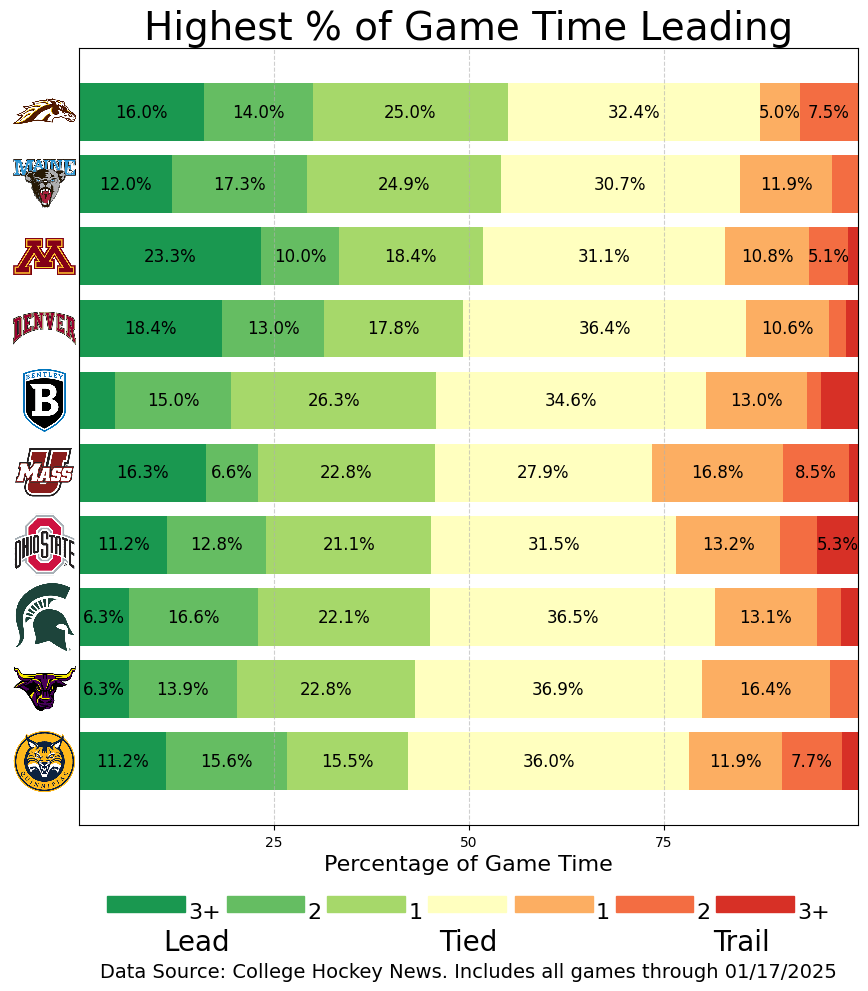

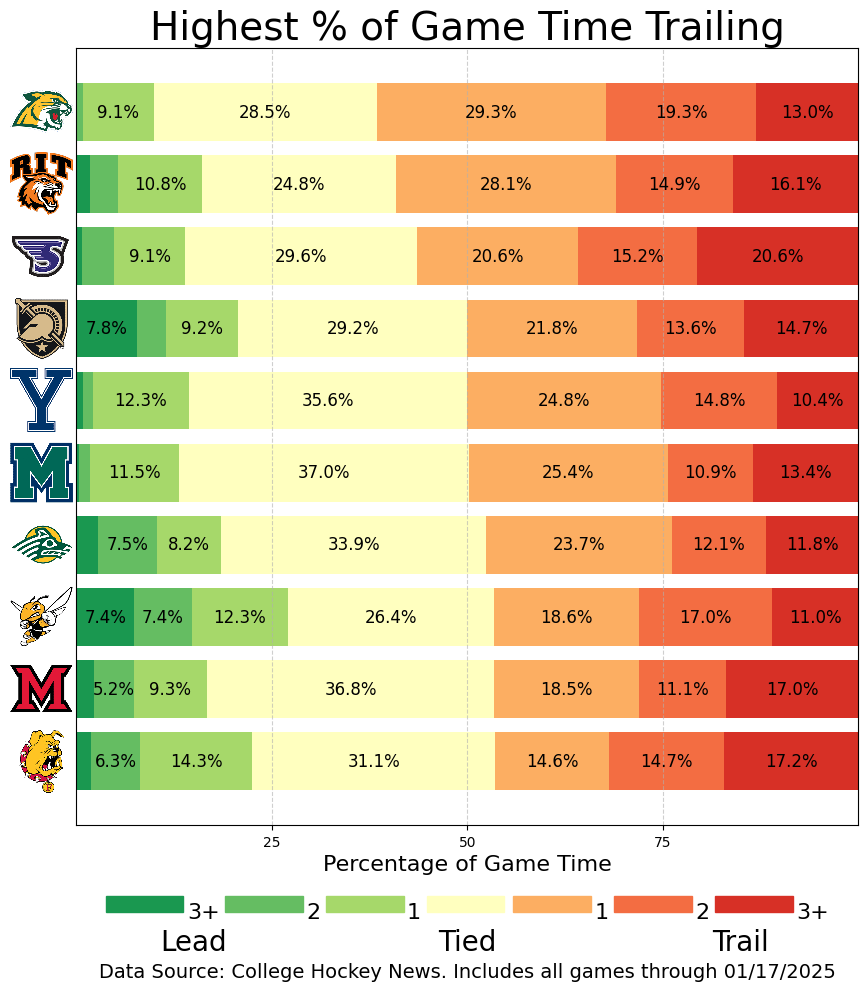

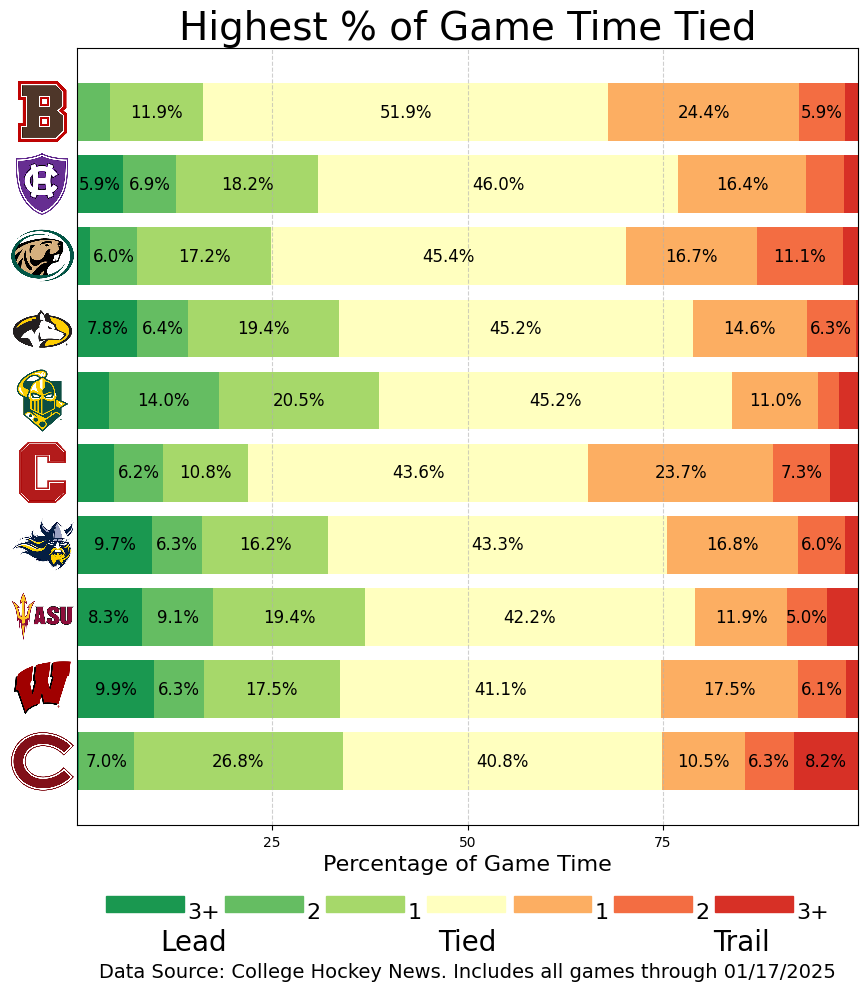

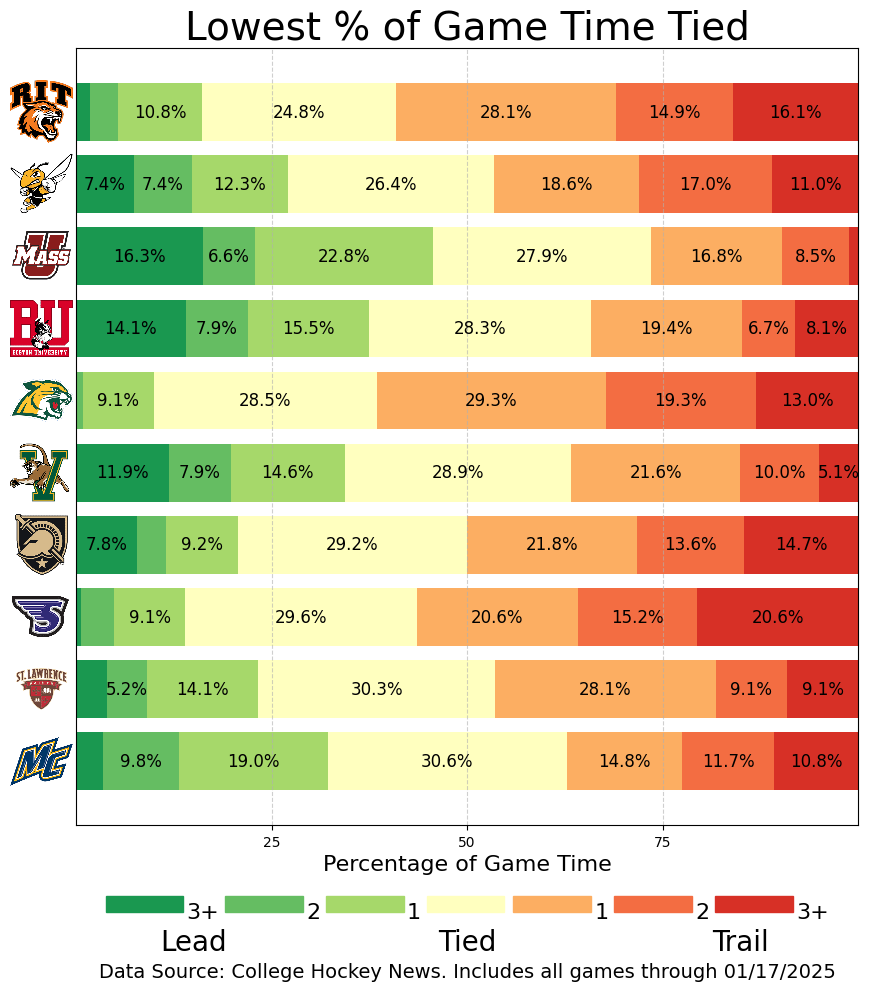

In [17]:

# Example usage:
plot_team_comparison(game_states_df, logo_mapping, logo_folder, plot_type='leading', top_n=10)
plot_team_comparison(game_states_df, logo_mapping, logo_folder, plot_type='trailing', top_n=10)
plot_team_comparison(game_states_df, logo_mapping, logo_folder, plot_type='tied', top_n=10)
plot_team_comparison(game_states_df, logo_mapping, logo_folder, plot_type='least_tied', top_n=10)


In [18]:
# ## Correct the names in the game_states_df to not have any non-letter characters
# # Reindex the game_states_df so Team is not the index
# game_states_df.reset_index(inplace=True)


# # print(game_states_df[game_states_df['Team'].str.contains('St. Lawrence')])

# # Remove periods from the team names
# game_states_df['Team'] = game_states_df['Team'].str.replace(r'\.', '')

# print(game_states_df[game_states_df['Team'].str.contains('St. Lawrence')])


In [19]:
game_states_df.head()
# Find St. Lawrence
game_states_df[game_states_df['Team'].str.contains('American')]

,Team,Tied,Trailing by 1,Trailing by 2,Trailing by 3+,Leading by 1,Leading by 2,Leading by 3+,Total_Time,Tied_Percentage,Leading_by_1_Percentage,Leading_by_2_Percentage,Leading_by_3+_Percentage,Trailing_by_1_Percentage,Trailing_by_2_Percentage,Trailing_by_3+_Percentage,Total_Leading_Percentage,Total_Trailing_Percentage,Total_Tied_Percentage
13,American Intl,20116.0,14144.0,12936.0,8398.0,9344.0,5622.0,5640.0,76200.0,26.39895,12.262467,7.377953,7.401575,18.56168,16.976378,11.020997,27.041995,46.559055,26.39895


## Call Plots by Conference

In [20]:
## Define TEMP DIRECTORY FOR IMAGE OUTPUT
temp_output_tie_plot_folder = os.path.join(os.getcwd(), '..', 'TEMP', 'IMAGES', 'tie_plots')

### Dictionary of Team Names and Abbreviations


## Conference Membership

atlantic = ['Air Force', "American Intl", 'Army', 'Bentley', 'Canisius', 'Holy Cross', 'Mercyhurst', 
            'Niagara', 'RIT', 'Robert Morris', 'Sacred Heart']

big_ten = ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin']

ccha = ['Augustana', 'Bemidji State', 'Bowling Green', 'Ferris State', 'Lake Superior', 'Michigan Tech', 
        'Minnesota State', 'Northern Michigan', 'St Thomas']

ecac = ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
        'Rensselaer', 'St Lawrence', 'Union', 'Yale']

hockey_east = ['Boston College', 'Boston University', 'Connecticut', 'Maine', 'Massachusetts', 'Mass Lowell',
                'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont']

nchc = ['Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 'St Cloud State',
        'Western Michigan']

independents = ['Alaska Anchorage', 'Alaska', 'Lindenwood', 'Long Island', 'Stonehill']


#### Conference by Conference Plot Function

In [21]:
# Create a function to call the plot_team_comparison function for each conference

def plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference, conference_text, top_n=10):
    """
    Plot stacked bar charts of game state percentages for the top `top_n` teams within a conference,
    with labels showing the percentage within each segment if space allows,
    and team logos replacing the team names on the y-axis.
    
    Parameters:
    - game_states_df: DataFrame containing game state data.
    - logo_mapping: Dictionary mapping team names to logo file names.
    - logo_folder: Folder path where logos are stored.
    - conference: List of team names in the conference.
    - top_n: Number of top teams to display.
    """
    
    # Filter the game states data for teams in the conference
    conference_df = game_states_df[game_states_df['Team'].isin(conference)]
    
    # Calculate the total percentages for leading, trailing, and tied states
    conference_df['Total_Leading_Percentage'] = (
        conference_df['Leading_by_1_Percentage'] +
        conference_df['Leading_by_2_Percentage'] +
        conference_df['Leading_by_3+_Percentage']
    )
    conference_df['Total_Trailing_Percentage'] = (
        conference_df['Trailing_by_1_Percentage'] +
        conference_df['Trailing_by_2_Percentage'] +
        conference_df['Trailing_by_3+_Percentage']
    )
    conference_df['Total_Tied_Percentage'] = conference_df['Tied_Percentage']

    # Select the top teams based on the chosen plot type
    top_teams_df = conference_df.nlargest(top_n, 'Total_Leading_Percentage')
    title = f"{conference_text}: Game Balance"
    subtitle = f"By Percentage of Time with a Lead"
    
    # Prepare data for plotting
    categories = [
        'Leading_by_3+_Percentage', 'Leading_by_2_Percentage', 'Leading_by_1_Percentage',
        'Tied_Percentage', 'Trailing_by_1_Percentage', 'Trailing_by_2_Percentage', 'Trailing_by_3+_Percentage'
    ]
    
    colors = [
        '#1A9850', '#65BD62', '#A6D86A',  # Leading: Shades of Green
        '#FFFFBF',                        # Tied: Yellow
        '#FCAE62', '#F36D42', '#D73026'   # Trailing: Shades of Red
    ]

    custom_labels = [
        'Lead 3+', 'Lead 2', 'Lead 1',
        'Tied', 'Down 1', 'Down 2', 'Down 3+'
    ]

    fig, ax = plt.subplots(figsize=set_fig_size)

    bottom = None
    for category, color in zip(categories, colors):
        if bottom is None:
            bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category)
            bottom = top_teams_df[category]
        else:
            bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category, left=bottom)
            bottom += top_teams_df[category]

        # Add labels to the segments where there's enough space
        for bar, value in zip(bars, top_teams_df[category]):
            if value > 5:  # Only show labels if the segment is larger than 5%
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + bar.get_height() / 2,
                    f"{value:.1f}%", ha='center', va='center', fontsize=12, color='black'
                )

    # Add team logos in place of the y-axis labels
    for i, team in enumerate(top_teams_df['Team']):
        logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))
        if logo_path and os.path.exists(logo_path):
            try:
                logo_img = plt.imread(logo_path)
                imagebox = OffsetImage(logo_img, zoom=0.15)
                ab = AnnotationBbox(imagebox, (0, i), frameon=False, boxcoords="offset points",
                                    xybox=(-30, 0), pad=0, xycoords='data')
                ax.add_artist(ab)
            except Exception as e:
                print(f"Error adding logo for {team}: {e}")

    # Remove y-axis labels since we are using logos
    ax.set_yticks([])

    # Customize the chart
    ax.set_xlabel('Percentage of Game Time', fontsize=set_x_label_font_size)
    ax.set_title(title, fontsize=title_font_size)
    # Set subtitle
    ax.text(0.5, 0.96, subtitle, ha='center', va='bottom', fontsize=16, transform=ax.transAxes)
    ax.set_xlim(0, 100)
    ax.set_xticks([0, 25, 50, 75, 100]) # Major Tick Marks
    # Set style for major tick marks
    ax.tick_params(axis='x', which='major', length=10, width=1)
    # Set grid for major tick marks
    ax.grid(which='major', axis='x', linestyle='--', alpha=0.6)
    # Set minor Tick Marks every 10%
    ax.set_xticks([10, 20, 30, 40, 60, 70, 80, 90,], minor=True)
    # Girid lines for minor ticks
    ax.grid(which='minor', axis='x', linestyle=':', alpha=0.6)

    # Create a custom legend layout
    #        # Add the refined legend to the plot
    add_refined_legend(ax, colors)

    # Remove the border of the main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ### ADDED TO REFINED LEGEND SUBFUNCTION
    # # Get todays date as a string for the footer
    # from datetime import date
    # today = date.today()
    # todays_date = today.strftime("%m/%d/%Y")

#  # add a note with the date the data was pulled and plotted
#     ax.text(0.5, -0.25, f'Data Source: College Hockey News. Includes all games through {todays_date}', ha='center', va='bottom',
#      fontsize=12, 
#     transform=ax.transAxes
#     )

    # plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.gca().invert_yaxis()

    # Save the plot as an image in the TEMP folder
    output_filename = f"{conference_text}_game_balance.png"
    # output_path = os.path.join(temp_output_tie_plot_folder, output_filename)
    output_path = os.path.join(temp_output_tie_plot_folder, output_filename)

    plt.savefig(output_path, bbox_inches='tight')


    plt.show()


# Example usage:


### OUTPUT TOP

C:\Users\jbanc\AppData\Local\Temp\ipykernel_3060\3792831036.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Leading_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_3060\3792831036.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Trailing_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_3060\3792831036.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

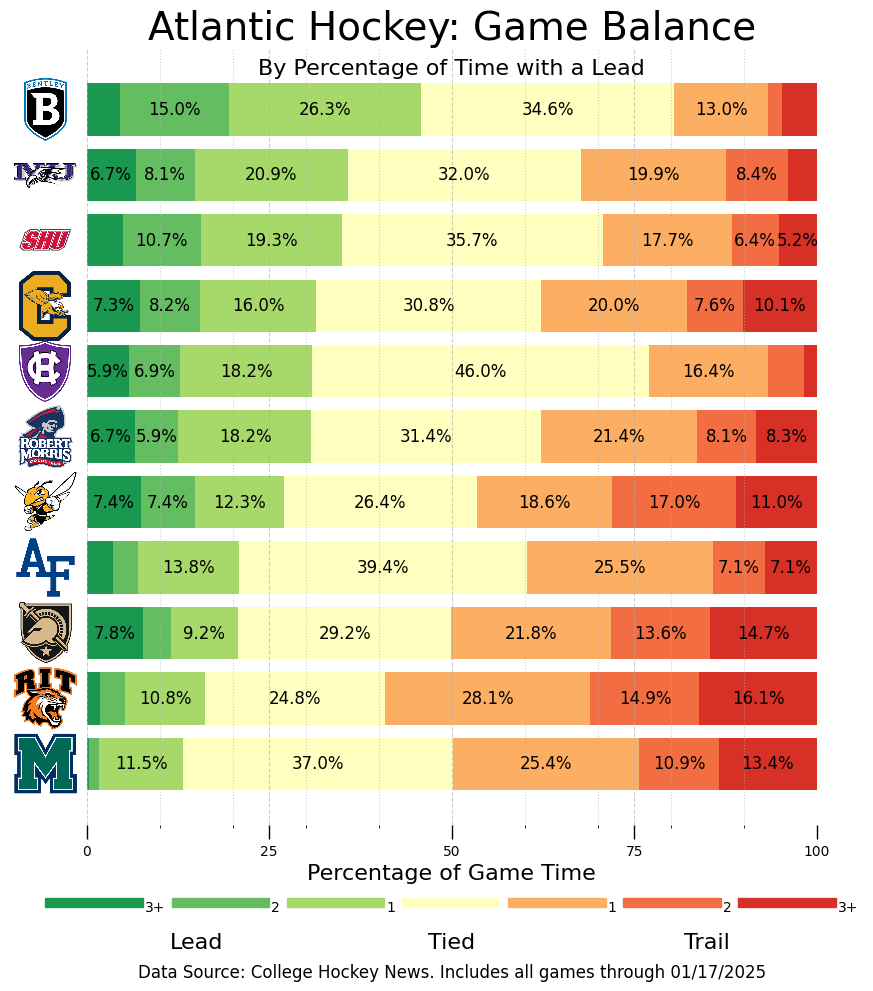

C:\Users\jbanc\AppData\Local\Temp\ipykernel_3060\3792831036.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Leading_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_3060\3792831036.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Trailing_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_3060\3792831036.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

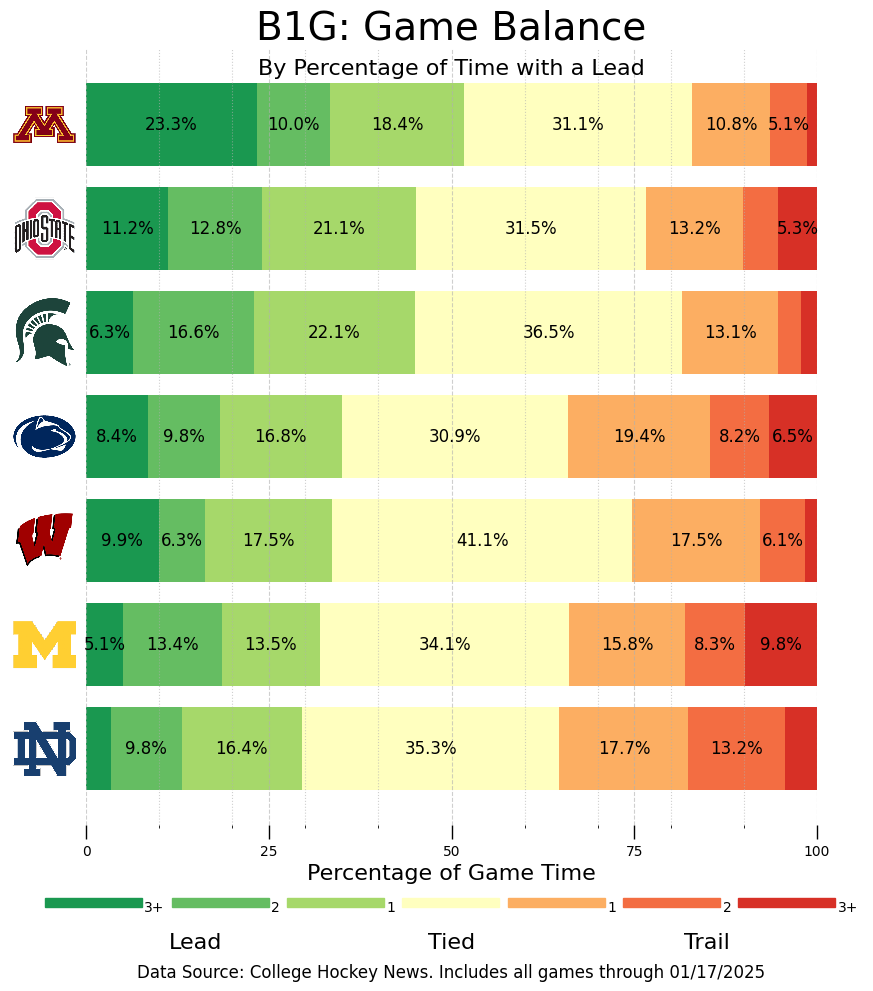

C:\Users\jbanc\AppData\Local\Temp\ipykernel_3060\3792831036.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Leading_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_3060\3792831036.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Trailing_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_3060\3792831036.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

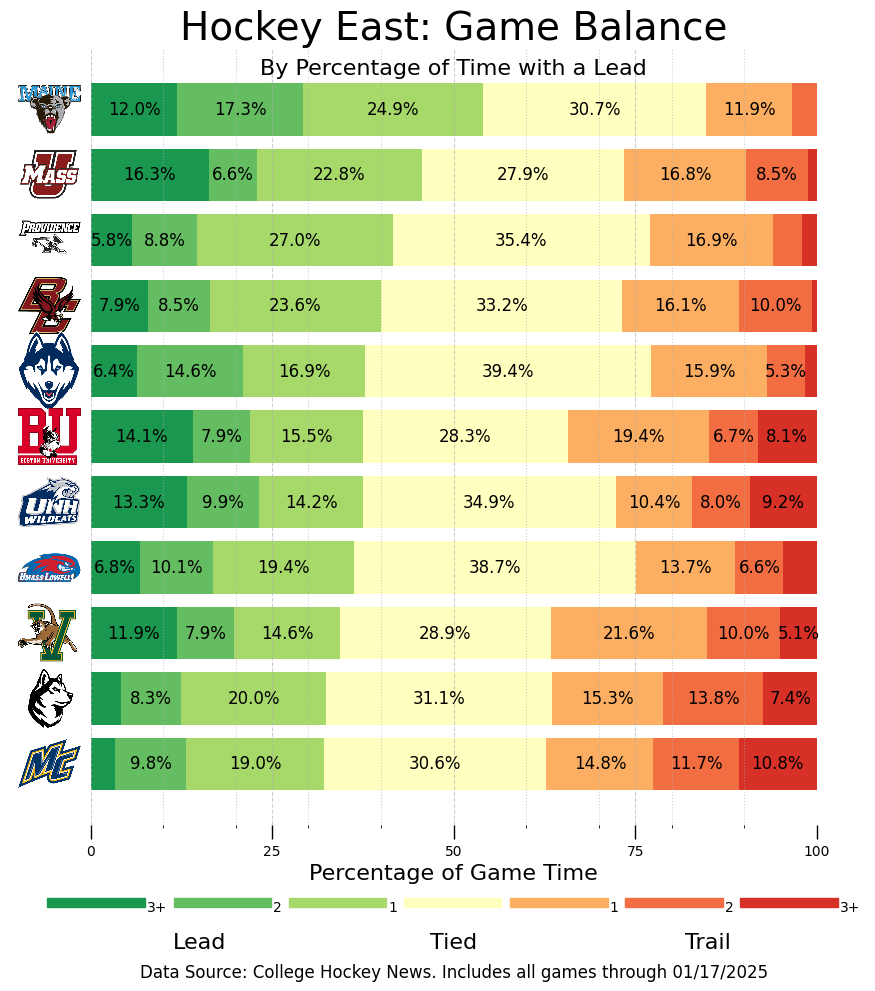

C:\Users\jbanc\AppData\Local\Temp\ipykernel_3060\3792831036.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Leading_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_3060\3792831036.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Trailing_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_3060\3792831036.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

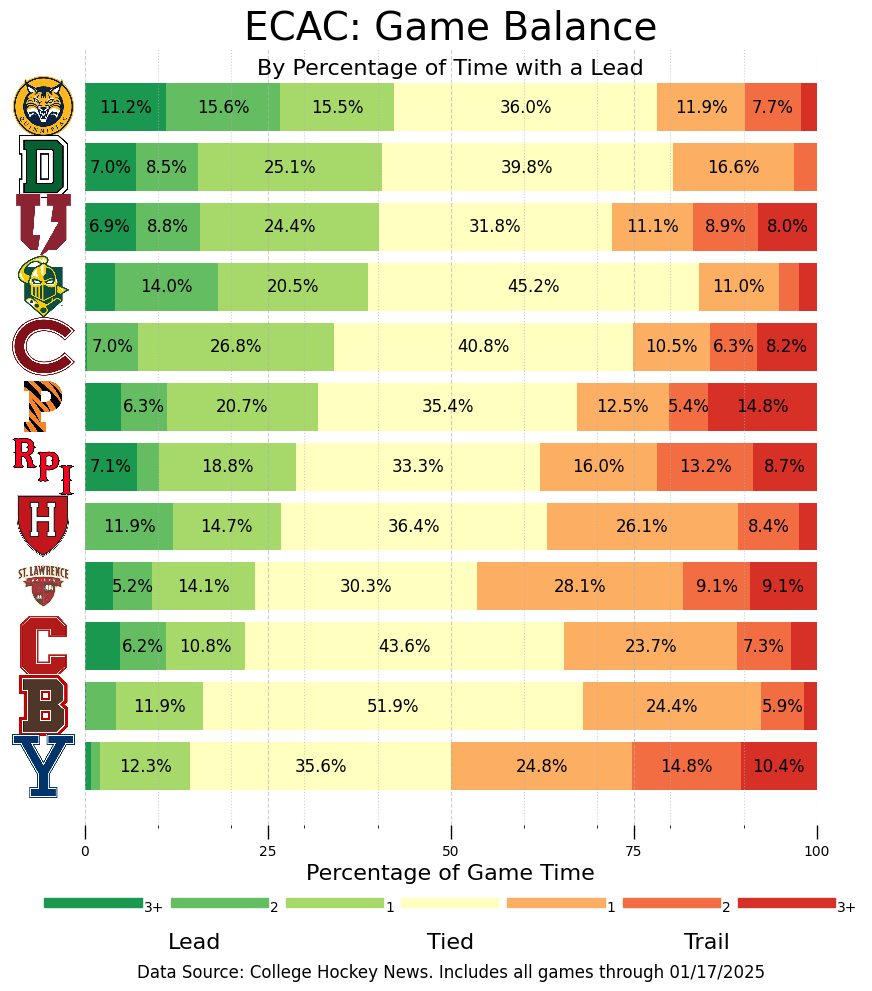

C:\Users\jbanc\AppData\Local\Temp\ipykernel_3060\3792831036.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Leading_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_3060\3792831036.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Trailing_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_3060\3792831036.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

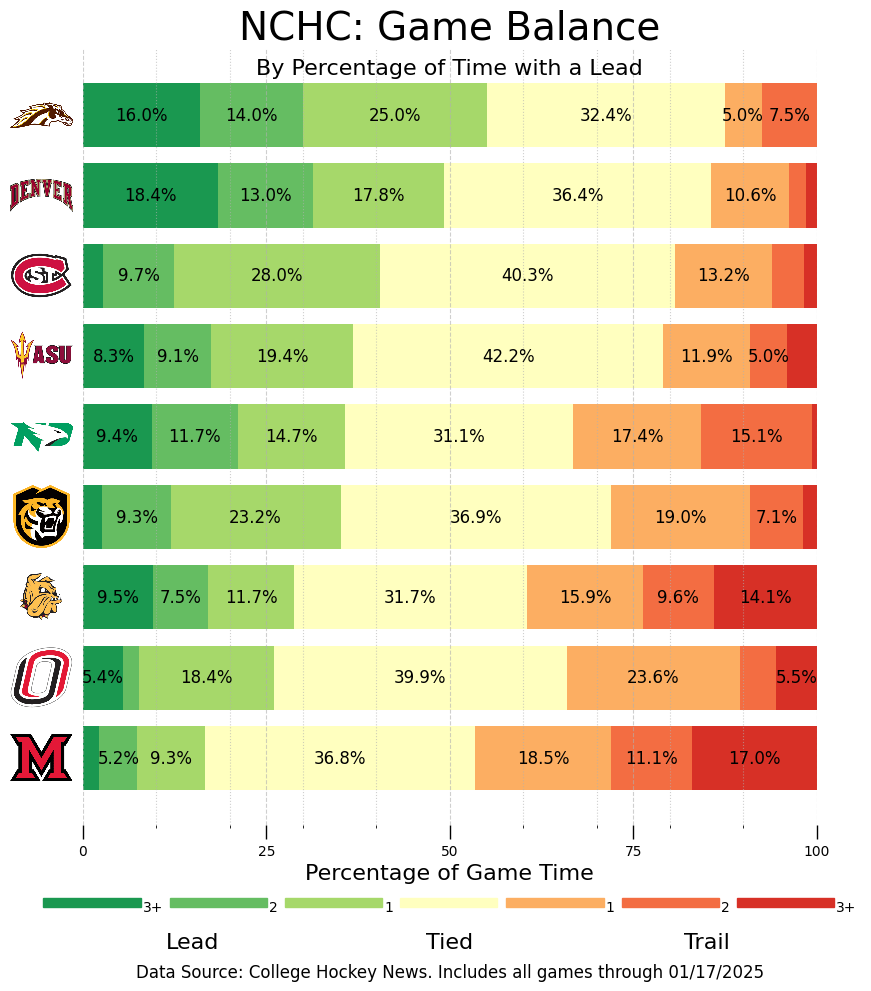

C:\Users\jbanc\AppData\Local\Temp\ipykernel_3060\3792831036.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Leading_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_3060\3792831036.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Trailing_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_3060\3792831036.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

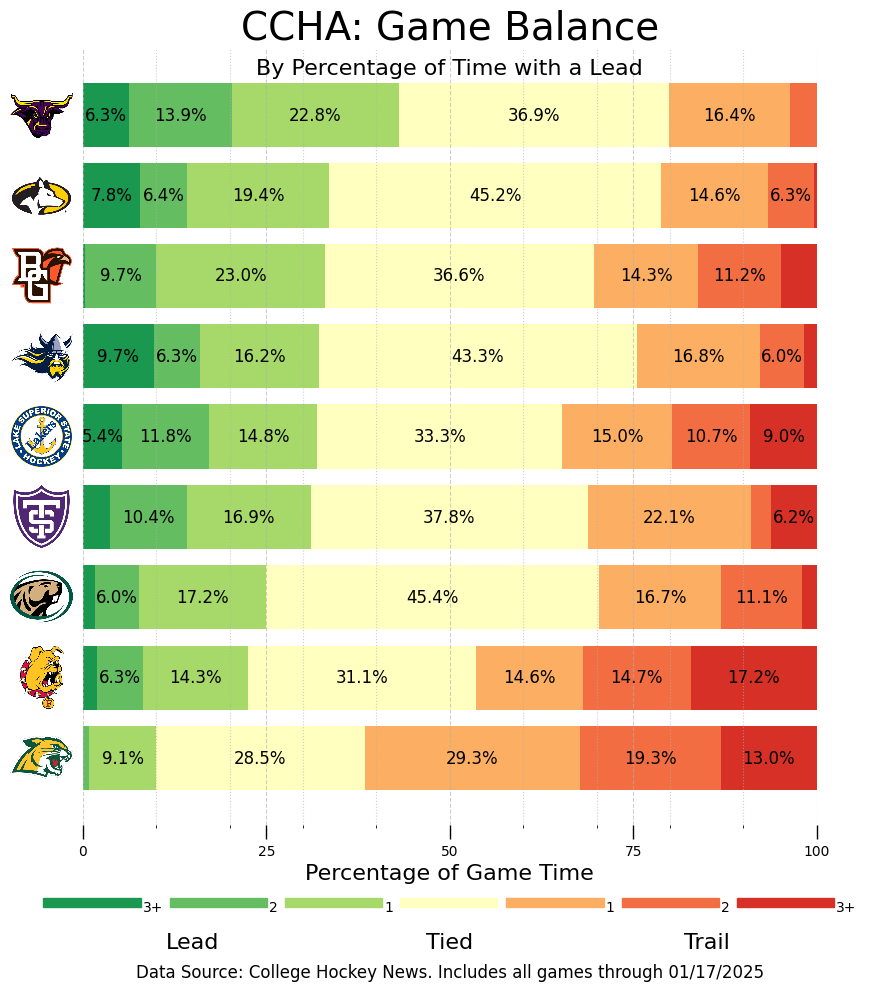

C:\Users\jbanc\AppData\Local\Temp\ipykernel_3060\3792831036.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Leading_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_3060\3792831036.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Trailing_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_3060\3792831036.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

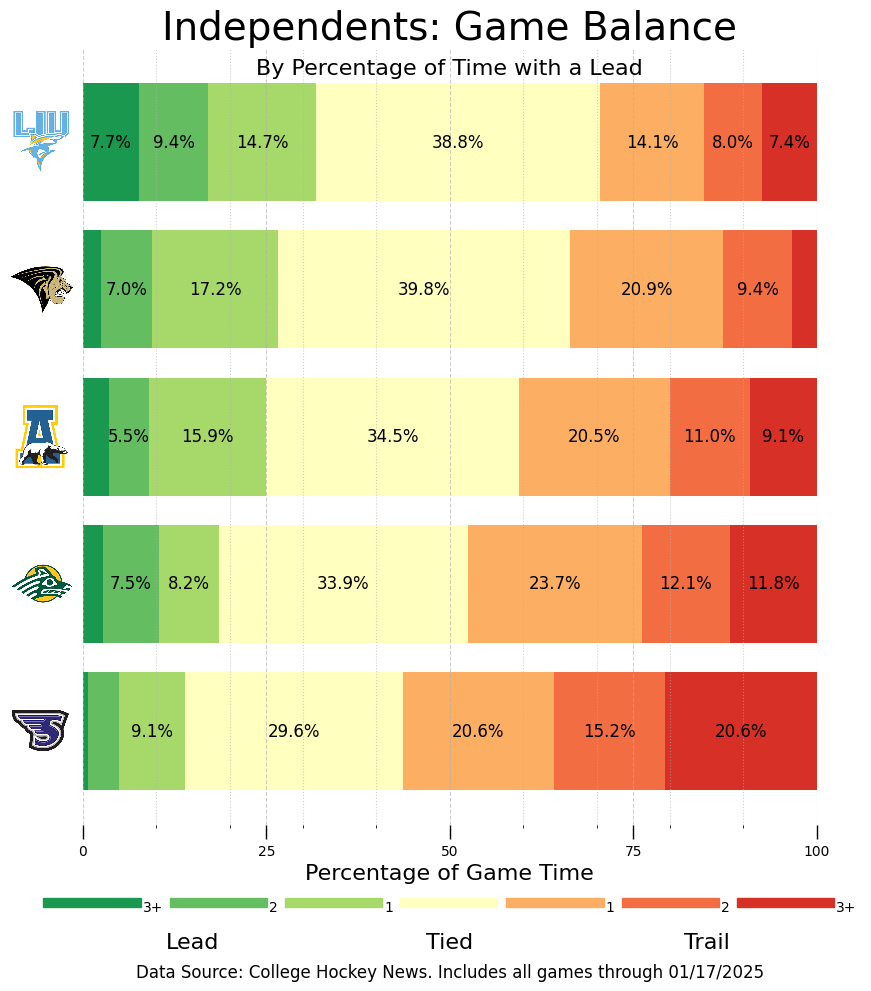

In [22]:



# Atlantic Hockey
plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=atlantic, conference_text='Atlantic Hockey', top_n=20)

#B1G
plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=big_ten, conference_text='B1G', top_n=20)

# Hockey East
plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=hockey_east, conference_text='Hockey East', top_n=20)

# ECAC
plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=ecac, conference_text='ECAC', top_n=20)

# NCHC
plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=nchc, conference_text='NCHC', top_n=20)

# CCHA
plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=ccha, conference_text='CCHA', top_n=20)

# Independents
plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=independents, conference_text='Independents', top_n=10)



## Full 62 Plot in Large format


In [23]:
### Plot the entire range of teams softed by time with a lead.

# The aspect ration willl be different for this plot - x10 - y 40? - 50?

tall_fig_size = (10, 35)

def plot_all_teams(game_states_df, logo_mapping, logo_folder, top_n=65):
    """
    Plot stacked bar charts of game state percentages for the top `top_n` teams,
    with labels showing the percentage within each segment if space allows,
    and team logos replacing the team names on the y-axis.
    
    Parameters:
    - game_states_df: DataFrame containing game state data.
    - logo_mapping: Dictionary mapping team names to logo file names.
    - logo_folder: Folder path where logos are stored.
    - top_n: Number of top teams to display.
    """
    
    # Calculate the total percentages for leading, trailing, and tied states
    game_states_df['Total_Leading_Percentage'] = (
        game_states_df['Leading_by_1_Percentage'] +
        game_states_df['Leading_by_2_Percentage'] +
        game_states_df['Leading_by_3+_Percentage']
    )
    game_states_df['Total_Trailing_Percentage'] = (
        game_states_df['Trailing_by_1_Percentage'] +
        game_states_df['Trailing_by_2_Percentage'] +
        game_states_df['Trailing_by_3+_Percentage']
    )
    game_states_df['Total_Tied_Percentage'] = game_states_df['Tied_Percentage']

    # Select the top teams based on the chosen plot type
    top_teams_df = game_states_df.nlargest(top_n, 'Total_Leading_Percentage')
    
    ############ SET THE TITLES ###############
    subtitle = f"% of Game Time with a Lead"
    title = f"Game Balance\n"
    

    # Prepare data for plotting
    categories = [
        'Leading_by_3+_Percentage', 'Leading_by_2_Percentage', 'Leading_by_1_Percentage',
        'Tied_Percentage', 'Trailing_by_1_Percentage', 'Trailing_by_2_Percentage', 'Trailing_by_3+_Percentage'
    ]
    
    colors = [
        '#1A9850', '#65BD62', '#A6D86A',  # Leading: Shades of Green
        '#FFFFBF',                        # Tied: Yellow
        '#FCAE62', '#F36D42', '#D73026'   # Trailing: Shades of Red
    ]

    custom_labels = [
        'Lead 3+', 'Lead 2', 'Lead 1',
        'Tied', 'Down 1', 'Down 2', 'Down 3+'
    ]

    # Sort by the total percentage of time leading
    top_teams_df = top_teams_df.sort_values('Total_Leading_Percentage', ascending=True)

    fig, ax = plt.subplots(figsize=tall_fig_size)

    # Adjust the spacing between the title, bars, and the legend
    plt.subplots_adjust(
        # top=0.92,   # Reduce space above the bar chart
        top = 1.0,
        bottom=0.15,  # Reduce space below the chart
        left=0.05,  # Leave some space on the left
        right=0.95  # Leave some space on the right
    )

    bottom = None
    for category, color in zip(categories, colors):
        if bottom is None:
            bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category)
            bottom = top_teams_df[category]
        else:
            bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category, left=bottom)
            bottom += top_teams_df[category]

        # Add labels to the segments where there's enough space
        for bar, value in zip(bars, top_teams_df[category]):
            if value > 5:  # Only show labels if the segment is larger than 5%
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + bar.get_height() / 2,
                    f"{value:.1f}%", ha='center', va='center', fontsize=12, color='black'
                )

    # Add team logos in place of the y-axis labels
    for i, team in enumerate(top_teams_df['Team']):
        logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))
        if logo_path and os.path.exists(logo_path):
            try:
                logo_img = plt.imread(logo_path)
                imagebox = OffsetImage(logo_img, zoom=0.10)
                ab = AnnotationBbox(imagebox, (0, i), frameon=False, boxcoords="offset points",
                                    xybox=(-30, 0), pad=0, xycoords='data')
                ax.add_artist(ab)
            except Exception as e:
                print(f"Error adding logo for {team}: {e}")

    # Remove y-axis labels since we are using logos
    ax.set_yticks([])

    # Customize the chart
    ax.set_xlabel('Percentage of Game Time', fontsize=set_x_label_font_size_2)
    ax.set_title(title, fontsize=title_font_size)
    # Add a Subtitle
    ax.text(0.5, 1.02, subtitle, ha='center', va='top', fontsize=16, transform=ax.transAxes)

    
    
    ## SET THE TICK MARK AND GRID LINE STYLE OPTIONS
    ax.set_xlim(0, 100)
    ax.set_xticks([0, 25, 50, 75, 100]) # Major Tick Marks
    # Add solid grid lines for major tick marks
    ax.grid(which='major', axis='x', linestyle='-', alpha=0.6)
    # Set minor Tick Marks every 10%
    ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], minor=True)
    # Girid lines for minor ticks
    ax.grid(which='minor', axis='x', linestyle='--', alpha=0.2)

    # add the tick labels to the top of the plot
    ax.xaxis.tick_top()

    # Set y axis limits - ADJUSTS THE EMPTY HEAD SPACE ABOVE THE BARS
    ax.set_ylim(-0.15, len(top_teams_df) - 0.5)

    # Create a custom legend layout
    ## Cutomized from original refined_legend function - 
    def tall_sheet_legend(ax, colors, legend_font_size=12):
        """
        Add a modern, streamlined legend to the plot with colors aligned horizontally,
        with two rows of text for the degree of lead/deficit and guide labels.
        """
        degree_labels = ["3+", "2", "1", "", "1", "2", "3+"]
        guide_labels = ["Lead", "Tied", "Trail"]
        
        legend_x = 0.5
        legend_y = -0.025  # Lower the legend to create more space
        legend_width = 0.95

        # Create rectangles for each color swatch
        swatches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]

        # Create a legend with swatches and the degree labels
        legend = ax.legend(
            swatches, degree_labels, loc='upper center',
            bbox_to_anchor=(legend_x, legend_y), ncol=len(colors), frameon=False,
            fontsize=legend_font_size_2, handlelength=4, 
            handletextpad=0.05, columnspacing=0.5
        #     swatches, degree_labels, loc='upper center',
        #     bbox_to_anchor=(legend_x, legend_y), ncol=len(colors), frameon=False,
        #     fontsize=legend_font_size, handlelength=2.5, handletextpad=0.2, columnspacing=1
        )
                

        for text, label in zip(legend.get_texts(), degree_labels):
            text.set_ha('center')
            text.set_va('center')

        set_offset = -0.05  # Lower the guide labels to create more space
        ax.text(
            0.15, set_offset, guide_labels[0], ha='center', va='center', transform=ax.transAxes, fontsize=legend_title_font_size
        )
        ax.text(
            0.5, set_offset, guide_labels[1], ha='center', va='center', transform=ax.transAxes, fontsize=legend_title_font_size
        )
        ax.text(
            0.85, set_offset, guide_labels[2], ha='center', va='center', transform=ax.transAxes, fontsize=legend_title_font_size
        )
        # # Add the date the data was pulled and plotted
        # Get todays date as a string for the footer
        from datetime import date
        today = date.today()
        todays_date = today.strftime("%m/%d/%Y")
        
        ax.text(
            0.5, set_offset + 0.025, 
            f'Data Source: College Hockey News. Includes all games through {todays_date}', ha='center', va='center',
            fontsize=12, transform=ax.transAxes

        )

        # # Add the date the data was pulled and plotted
        # from datetime import date
        # today = date.today()
        # todays_date = today.strftime("%m/%d/%Y")
        # ax.text(0.5, -0.0125, f'Data Source: College Hockey News. Includes all games through {todays_date}', ha='center', va='bottom',
        #  fontsize=12,
        # transform=ax.transAxes
        # )

    # Add the updated legend to the plot
    tall_sheet_legend(ax, colors)

    # Remove the border of the main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Save the plot as an image in the TEMP folder
    output_filename = f"all_teams_game_balance.png"
    output_path = os.path.join(temp_output_tie_plot_folder, output_filename)

    # Adjust bottom margin and save the plot
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0.5)
    plt.show()



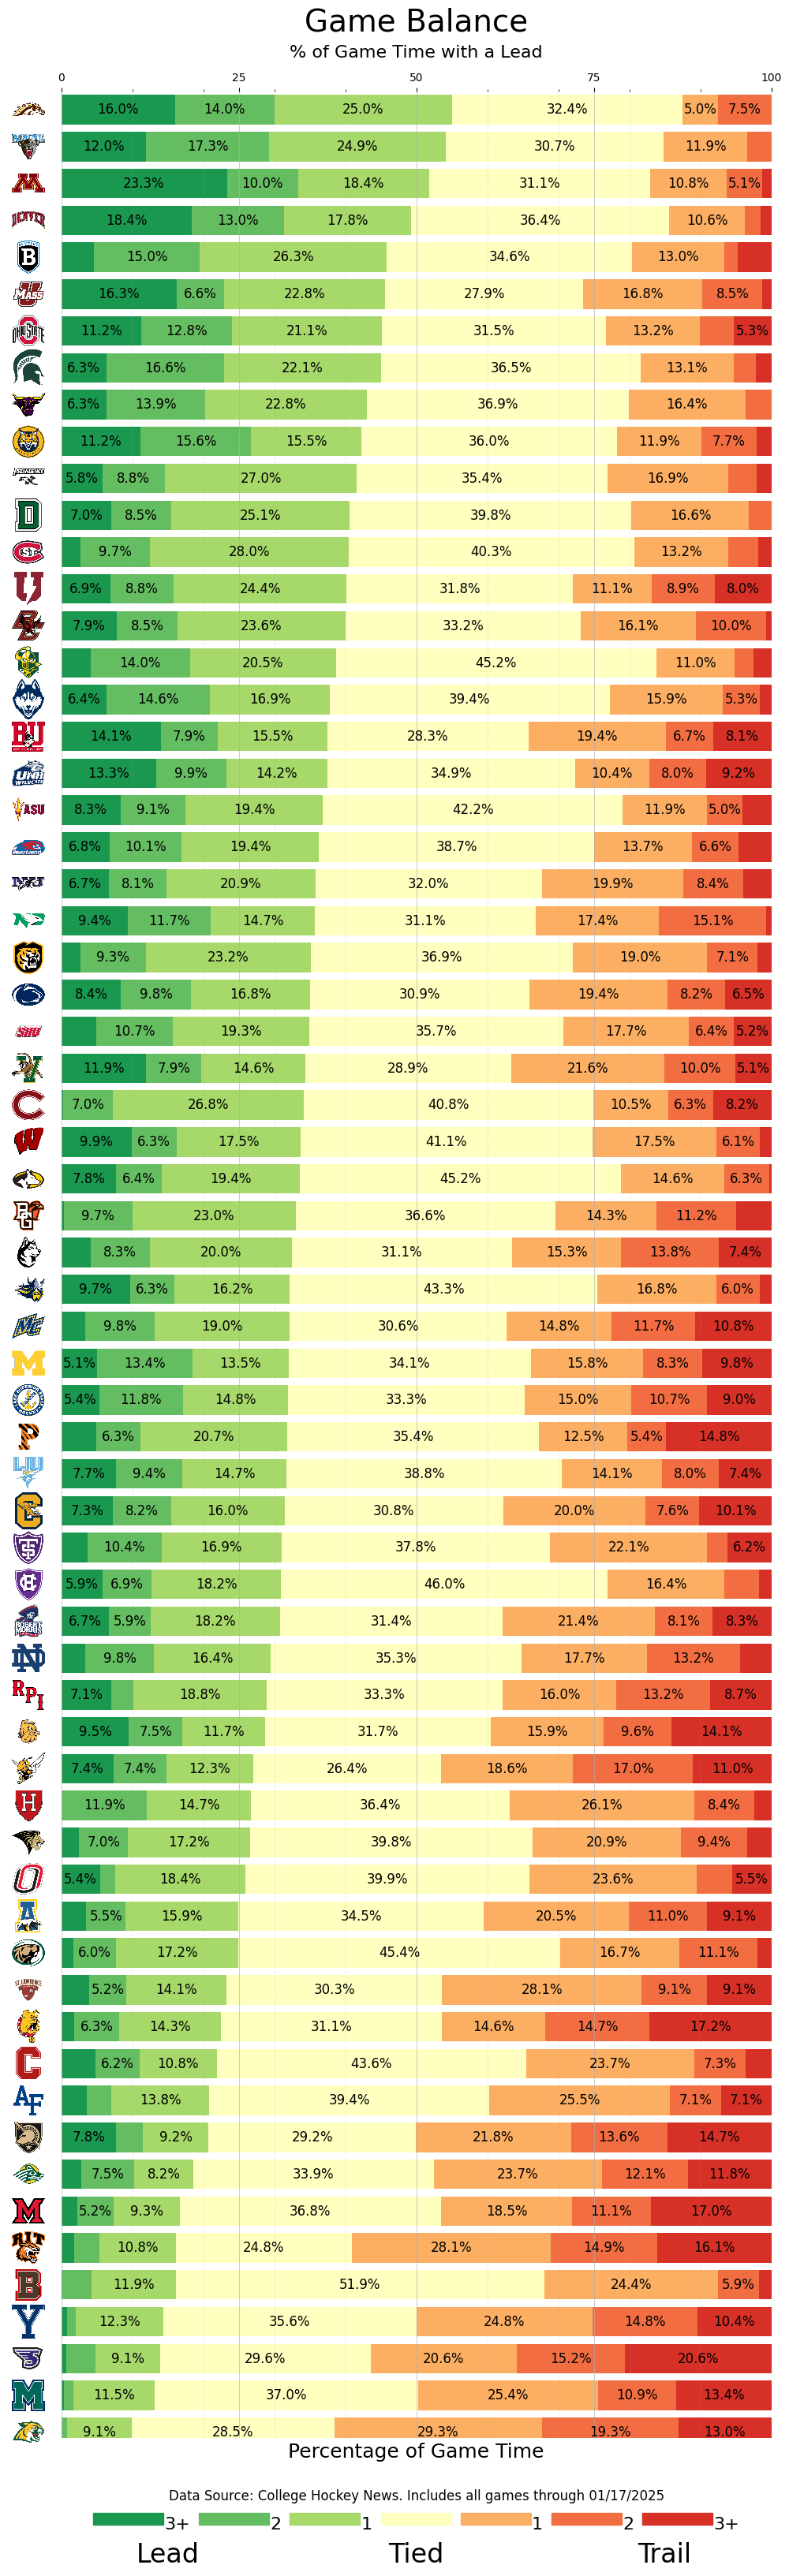

In [24]:
# Call the function to plot all teams
plot_all_teams(game_states_df, logo_mapping, logo_folder, top_n=65)

#### Plot the all 64 by pairwise rank

# NOT WORKING

In [25]:
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# Step 1: Set up Chrome options
options = Options()
options.add_argument('--headless')  # Run in headless mode (no browser window)
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# Step 2: Initialize the WebDriver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# Step 3: Open the webpage
url = 'https://www.collegehockeynews.com/ratings/pairwise/'
driver.get(url)

try:
    # Step 4: Wait for the table to be present in the DOM
    wait = WebDriverWait(driver, 10)
    table = wait.until(EC.presence_of_element_located((By.TAG_NAME, 'table')))
    
    # Step 5: Debugging - Print the page source to verify if the table exists
    print("Page source length:", len(driver.page_source))

    # Step 6: Extract headers
    headers = [th.text for th in table.find_elements(By.TAG_NAME, 'th')]
    
    # Step 7: Extract rows
    rows = []
    for row in table.find_elements(By.TAG_NAME, 'tr')[1:]:  # Skip the header row
        cells = [cell.text for cell in row.find_elements(By.TAG_NAME, 'td')]
        if cells:
            rows.append(cells)

    # Step 8: Convert to DataFrame
    df = pd.DataFrame(rows, columns=headers)

    # Step 9: Display the DataFrame
    print(df)

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Close the browser
    driver.quit()


Page source length: 554023
   Rk            Team PCWs    RPI Rk  QWB-†         W-L-T PwWin %  \
0   1  Boston College   63  .6321  1  .0156  15-4-1 (2-0)   .7417   
1   2  Michigan State   62  .6264  2  .0101  18-3-2 (3-1)   .7971   
2   3       Minnesota   61  .6062  3  .0043  19-4-2 (1-1)   .8000   
3   4          Denver   60  .5922  4  .0040  17-5-0 (1-0)   .7576   
4   5           Maine   59  .5921  5  .0077  15-5-2 (1-0)   .7121   
.. ..             ...  ...    ... ..    ...           ...     ...   
59                                                                  
60                                                                  
61                                                                  
62                                                                  
63                                                                  

   Wgtd Win % - ‡  
0           .7491  
1           .8131  
2           .7950  
3           .7640  
4           .6963  
..            ...  
59  

In [26]:
df.head(25)


,Rk,Team,PCWs,RPI,Rk,QWB-†,W-L-T,PwWin %,Wgtd Win % - ‡
0,1,Boston College,63,.6321,1,.0156,15-4-1 (2-0),.7417,.7491
1,2,Michigan State,62,.6264,2,.0101,18-3-2 (3-1),.7971,.8131
2,3,Minnesota,61,.6062,3,.0043,19-4-2 (1-1),.8000,.7950
3,4,Denver,60,.5922,4,.0040,17-5-0 (1-0),.7576,.7640
4,5,Maine,59,.5921,5,.0077,15-5-2 (1-0),.7121,.6963
5,6,Providence,58,.5879,6,.0028,15-4-2 (4-1),.7143,.7170
6,7,Western Michigan,57,.5808,7,.0036,13-4-1 (2-1),.7315,.7280
7,8,Boston University,56,.5798,8,.0048,12-7-1 (0-1),.6417,.6339
8,9,Connecticut,55,.5797,9,.0078,12-8-1 (1-2),.6111,.6221
9,10,Ohio State,53,.5714,10,.0040,15-6-1 (2-1),.6894,.6981


In [27]:

## Join the Pairwise Rankings with the Game States Data

# Clean trouble Team names
# Replace Alaska-Anchorage with Alaska Anchorage
df['Team'] = df['Team'].str.replace('Alaska-Anchorage', 'Alaska Anchorage')
# Minnesota-Duluth with Minnesota Duluth
df['Team'] = df['Team'].str.replace('Minnesota-Duluth', 'Minnesota Duluth')
## Mass.-Lowell with Mass. Lowell
df['Team'] = df['Team'].str.replace('Mass.-Lowell', 'Mass. Lowell')


# Step 1: Merge the Pairwise Rankings with the Game States Data
merged_df = pd.merge(df, game_states_df, how='outer', left_on='Team', right_on='Team')

# Step 2: Display the info on the merged DataFrame to check for unexpected null values
print(merged_df.info())

# Output a csv file with the merged data for manual inspection
merged_output_path = os.path.join(temp_folder, 'merged_pairwise_game_states.csv')
merged_df.to_csv(merged_output_path, index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rk                         64 non-null     object 
 1   Team                       111 non-null    object 
 2   PCWs                       64 non-null     object 
 3   RPI                        64 non-null     object 
 4   Rk                         64 non-null     object 
 5   QWB-†                      64 non-null     object 
 6   W-L-T                      64 non-null     object 
 7   PwWin %                    64 non-null     object 
 8   Wgtd Win % - ‡             64 non-null     object 
 9   Tied                       64 non-null     float64
 10  Trailing by 1              64 non-null     float64
 11  Trailing by 2              64 non-null     float64
 12  Trailing by 3+             64 non-null     float64
 13  Leading by 1               64 non-null     float64

In [28]:
merged_df.to_csv(merged_output_path, index=False)

## OLD CODE - INITIAL VERSIONS


In [29]:
# import matplotlib.pyplot as plt

# def plot_top_teams_by_leading_percentage(game_states_df, top_n=10):
#     """
#     Plot stacked bar charts of game state percentages for the top `top_n` teams
#     that have spent the highest percentage of time leading in games.
#     """
#     # Calculate the total leading percentage
#     game_states_df['Total_Leading_Percentage'] = (
#         game_states_df['Leading_by_1_Percentage'] +
#         game_states_df['Leading_by_2_Percentage'] +
#         game_states_df['Leading_by_3+_Percentage']
#     )
    
#     # Select the top teams by leading percentage
#     top_teams_df = game_states_df.nlargest(top_n, 'Total_Leading_Percentage')
    
#     # Prepare data for plotting
#     categories = [
#         'Leading_by_3+_Percentage', 'Leading_by_2_Percentage', 'Leading_by_1_Percentage',
#         'Tied_Percentage', 'Trailing_by_1_Percentage', 'Trailing_by_2_Percentage', 'Trailing_by_3+_Percentage'
#     ]
    
#     # colors = [
#     #     '#1A9850', '#65BD62', '#A6D86A',  # Leading: Dark Blue, Light Blue, Steel Blue
#     #     '#FFFFBF',                        # Tied: Dark Gray
#     #     '#FCAE62', '#F36D42', '#D73026'   # Trailing: Light Red, Orange Red, Dark Red
#     # ]
    
#     # Plot stacked bar chart
#     fig, ax = plt.subplots(figsize=set_fig_size)
    
#     bottom = None
#     for category, color in zip(categories, colors):
#         if bottom is None:
#             ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category)
#             bottom = top_teams_df[category]
#         else:
#             ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category, left=bottom)
#             bottom += top_teams_df[category]
    
#     # Customize the chart
#     ax.set_xlabel('Percentage of Game Time')
#     ax.set_ylabel('Team')
#     ax.set_title(f'Top {top_n} Teams by Percentage of Time Leading')
#     ax.set_xlim(0, 100)
#     ax.legend(loc='upper right')
#     plt.grid(axis='x', linestyle='--', alpha=0.6)
#     plt.tight_layout()
#     plt.gca().invert_yaxis()  # Ensure top team is at the top of the chart
    
#     # Show the plot
#     plt.show()

# # Call the function to plot the chart
# plot_top_teams_by_leading_percentage(game_states_df)


In [30]:
# import matplotlib.pyplot as plt

# def plot_top_teams_with_labels(game_states_df, top_n=10):
#     """
#     Plot stacked bar charts of game state percentages for the top `top_n` teams,
#     with labels showing the percentage within each segment if space allows.
#     """
#     # Calculate the total leading percentage
#     game_states_df['Total_Leading_Percentage'] = (
#         game_states_df['Leading_by_1_Percentage'] +
#         game_states_df['Leading_by_2_Percentage'] +
#         game_states_df['Leading_by_3+_Percentage']
#     )
    
#     # Select the top teams by leading percentage
#     top_teams_df = game_states_df.nlargest(top_n, 'Total_Leading_Percentage')
    
#     # Prepare data for plotting
#     categories = [
#         'Leading_by_3+_Percentage', 'Leading_by_2_Percentage', 'Leading_by_1_Percentage',
#         'Tied_Percentage', 'Trailing_by_1_Percentage', 'Trailing_by_2_Percentage', 'Trailing_by_3+_Percentage'
#     ]
    
#     colors = [
#         '#1A9850', '#65BD62', '#A6D86A',  # Leading: Shades of Green
#         '#FFFFBF',                        # Tied: Yellow
#         '#FCAE62', '#F36D42', '#D73026'   # Trailing: Shades of Red
#     ]

#     custom_labels = [
#         'Lead 3+', 'Lead 2', 'Lead 1', 
#         'Tied', 'Down 1', 'Down 2', 'Down 3+'
#     ]
    
#     fig, ax = plt.subplots(figsize=set_fig_size)
    
#     bottom = None
#     for category, color in zip(categories, colors):
#         if bottom is None:
#             bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category)
#             bottom = top_teams_df[category]
#         else:
#             bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category, left=bottom)
#             bottom += top_teams_df[category]
        
#         # Add labels to the segments where there's enough space
#         for bar, value in zip(bars, top_teams_df[category]):
#             if value > 5:  # Only show labels if the segment is larger than 5%
#                 ax.text(
#                     bar.get_x() + bar.get_width() / 2,  # Center of the segment
#                     bar.get_y() + bar.get_height() / 2,  # Center of the bar
#                     f"{value:.1f}%",  # Label with one decimal place
#                     ha='center', va='center', fontsize=12, color='black'
#                 )
    
#     # Customize the chart
#     ax.set_xlabel('Percentage of Game Time')
#     # ax.set_ylabel('Team')
#     ax.set_title(f'Top {top_n} Teams by Percentage of Time Leading')
#     ax.set_xlim(0, 100)
#     ax.set_xticks([25, 50, 75])  # Set custom tick marks at 25, 50, and 75
    
#     # Customize the legend with 3 rows
#     handles, _ = ax.get_legend_handles_labels()
#     ax.legend(
#         handles, custom_labels, loc='upper center',
#         bbox_to_anchor=(0.5, -0.05), 
#         ncol=4,
#         frameon=False, fontsize=10,
#         # title='Game States', title_fontsize=12,
#         columnspacing=1.0, handletextpad=0.5,
#         labelspacing=1.0
#     )
#     # ax.legend(loc='upper right')

#     plt.grid(axis='x', linestyle='--', alpha=0.6)
#     plt.tight_layout()
#     plt.gca().invert_yaxis()  # Ensure top team is at the top of the chart
    
#     # Show the plot
#     plt.show()

# # Call the function to plot the chart with labels
# plot_top_teams_with_labels(game_states_df)


### Time Spent Tied

In [31]:
# ## Create a compilmentary function to plot the top teams by trailing percentage

# def plot_top_teams_by_trailing_percentage(game_states_df, top_n=10):
#     """
#     Plot stacked bar charts of game state percentages for the top `top_n` teams
#     that have spent the highest percentage of time trailing in games.
#     """
#     # Calculate the total trailing percentage
#     game_states_df['Total_Trailing_Percentage'] = (
#         game_states_df['Trailing_by_1_Percentage'] +
#         game_states_df['Trailing_by_2_Percentage'] +
#         game_states_df['Trailing_by_3+_Percentage']
#     )
    
#     # Select the top teams by trailing percentage
#     top_teams_df = game_states_df.nlargest(top_n, 'Total_Trailing_Percentage')

#     # Reorder the teams by total trailing percentage
#     top_teams_df = top_teams_df.sort_values('Total_Trailing_Percentage', ascending=True)
    
#     # Prepare data for plotting
#     categories = [
#         'Leading_by_3+_Percentage', 'Leading_by_2_Percentage', 'Leading_by_1_Percentage',
#         'Tied_Percentage', 'Trailing_by_1_Percentage', 'Trailing_by_2_Percentage', 'Trailing_by_3+_Percentage'
#     ]
    
#     colors = [
#         '#1A9850', '#65BD62', '#A6D86A',  # Leading: Dark Blue, Light Blue, Steel Blue
#         '#FFFFBF',                        # Tied: Dark Gray
#         '#FCAE62', '#F36D42', '#D73026'   # Trailing: Light Red, Orange Red, Dark Red
#     ]

                   
#     # Plot stacked bar chart
#     fig, ax = plt.subplots(figsize=set_fig_size)
    
#     bottom = None
#     for category, color in zip(categories, colors):
#         if bottom is None:
#             ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category)
#             bottom = top_teams_df[category]
#         else:
#             ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category, left=bottom)
#             bottom += top_teams_df[category]
    
#     # Customize the chart
#     ax.set_xlabel('Percentage of Time Spent in Game State')
#     ax.set_ylabel('Team')
#     ax.set_title(f'Top {top_n} Teams by Percentage of Time Trailing')
#     ax.set_xlim(0, 100)
#     ax.legend(loc='lower center')
#     plt.grid(axis='x', linestyle='--', alpha=0.6)
#     plt.tight_layout()
#     # plt.gca().invert_yaxis

    
    
    

    

# ## Call the function to plot the chart
# plot_top_teams_by_trailing_percentage(game_states_df)

### Top Ten Time Spent Tied

In [32]:
# ## Adapt the plot to show the top teams by tied percentage

# def plot_top_teams_by_tied_percentage(game_states_df, top_n=10):
#     """
#     Plot stacked bar charts of game state percentages for the top `top_n` teams
#     that have spent the highest percentage of time tied in games.
#     """
#     # Select the top teams by tied percentage
#     top_teams_df = game_states_df.nlargest(top_n, 'Tied_Percentage')
    
#     # Prepare data for plotting
#     categories = [
#         'Leading_by_3+_Percentage', 'Leading_by_2_Percentage', 'Leading_by_1_Percentage',
#         'Tied_Percentage', 'Trailing_by_1_Percentage', 'Trailing_by_2_Percentage', 'Trailing_by_3+_Percentage'
#     ]
    
#     colors = [
#         '#1A9850', '#65BD62', '#A6D86A',  # Leading: Dark Blue, Light Blue, Steel Blue
#         '#FFFFBF',                        # Tied: Dark Gray
#         '#FCAE62', '#F36D42', '#D73026'   # Trailing: Light Red, Orange Red, Dark Red
#     ]
    
#     # Plot stacked bar chart
#     fig, ax = plt.subplots(figsize=set_fig_size)
    
#     bottom = None
#     for category, color in zip(categories, colors):
#         if bottom is None:
#             ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category)
#             bottom = top_teams_df[category]
#         else:
#             ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category, left=bottom)
#             bottom += top_teams_df[category]
    
#     # Customize the chart
#     ax.set_xlabel('Percentage of Time Spent in Game State')
#     ax.set_ylabel('Team')
#     ax.set_title(f'Top {top_n} Teams by Percentage of Time Tied')
#     ax.set_xlim(0, 100)
#     ax.legend(loc='upper right')
#     plt.grid(axis='x', linestyle='--', alpha=0.6)
#     plt.tight_layout()
#     plt.gca().invert_yaxis()  # Ensure top team is at the top of the chart
    
#     # Show the plot
#     plt.show()


# ## Call the function to plot the chart
# plot_top_teams_by_tied_percentage(game_states_df)

In [33]:
# import numpy as np
# import matplotlib.patches as patches

# colors = [
#     '#1A9850', '#65BD62', '#A6D86A',  # Leading: Dark Blue, Light Blue, Steel Blue
#     '#FFFFBF',                        # Tied: Dark Gray
#     '#FCAE62', '#F36D42', '#D73026'   # Trailing: Light Red, Orange Red, Dark Red
# ]

# def plot_top_teams_with_smooth_transitions(game_states_df, top_n=10):
#     """
#     Plot stacked bar charts of game state percentages for the top `top_n` teams
#     with smooth ribbon-like transitions between segments.
#     """
#     # Calculate the total leading percentage
#     game_states_df['Total_Leading_Percentage'] = (
#         game_states_df['Leading_by_1_Percentage'] +
#         game_states_df['Leading_by_2_Percentage'] +
#         game_states_df['Leading_by_3+_Percentage']
#     )
    
#     # Select the top teams by leading percentage
#     top_teams_df = game_states_df.nlargest(top_n, 'Total_Leading_Percentage')
    
#     # Prepare data for plotting
#     categories = [
#         'Leading_by_3+_Percentage', 'Leading_by_2_Percentage', 'Leading_by_1_Percentage',
#         'Tied_Percentage', 'Trailing_by_1_Percentage', 'Trailing_by_2_Percentage', 'Trailing_by_3+_Percentage'
#     ]

#     ## OLD PALLETE    
#     # colors = [
#     #     '#1E90FF', '#87CEFA', '#4682B4',  # Leading: Dark Blue, Light Blue, Steel Blue
#     #     '#A9A9A9',                        # Tied: Dark Gray
#     #     '#FF7F7F', '#FF4500', '#B22222'   # Trailing: Light Red, Orange Red, Dark Red
#     # ]
    
#     fig, ax = plt.subplots(figsize=set_fig_size)
#     y_positions = np.arange(len(top_teams_df))
#     # bar_height = 0.85
    
#     for idx, team in enumerate(top_teams_df['Team']):
#         left = 0
#         for category, color in zip(categories, colors):
#             width = top_teams_df.loc[top_teams_df['Team'] == team, category].values[0]
#             if width > 0:
#                 # Draw a rounded rectangle for smooth transitions
#                 ax.add_patch(patches.FancyBboxPatch(
#                     (left, y_positions[idx] - bar_height / 2),
#                     width,
#                     bar_height,
#                     boxstyle="round,pad=0.05",
#                     edgecolor='none',
#                     facecolor=color
#                 ))
#                 left += width
    
#     # Customize the chart
#     ax.set_yticks(y_positions)
#     ax.set_yticklabels(top_teams_df['Team'])
#     ax.set_xlabel('Percentage of Game Time')
#     ax.set_title(f'Top {top_n} Teams by Percentage of Time Leading')
#     ax.set_xlim(0, 100) # Set X axis limits
#     # Set y axis limits
#     ax.set_ylim(-0.5, len(top_teams_df) - 0.5)

#     ax.grid(axis='x', linestyle='--', alpha=0.6)
#     plt.gca().invert_yaxis()  # Ensure top team is at the top of the chart
#     plt.tight_layout()
    
#     # Display the plot
#     plt.show()

# # Call the function to generate the plot with smooth transitions
# plot_top_teams_with_smooth_transitions(game_states_df)
